## Sample Analysis for Tracker Observables

Begin by importing the allmighty `numpy` and `pyplot`

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random 

from os import listdir
import re

# Weight Events

Small bit of code which weights the simulated muon neutrinos according to the expected number of events at FaserNu

In [2]:
def weight_muon_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 1000
    numSimLead = 5 * 1000
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        energy = event['primaryEnergy']
        zpos   = event['zposition']

        mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
        numExp = expTotal[mask]
        if zpos < 120: # If interacted in tungsten
            weight = tungWeight * numExp / numSimTung
        else:
            weight = leadWeight * numExp / numSimLead

        event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element

def weight_elec_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-12.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_12.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 300
    numSimLead = 5 * 300
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        energy = event['primaryEnergy']
        zpos   = event['zposition']

        mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
        numExp = expTotal[mask]
        if zpos < 120: # If interacted in tungsten
            weight = tungWeight * numExp / numSimTung
        else:
            weight = leadWeight * numExp / numSimLead

        event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element

def weight_muons(files):
    
    data = np.array([])
    
    # Load fluence files for muons and anti-muons and combine them
    expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
    expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')
    
    expEnergy = expectedData1[:,0]
    expFlu    = expectedData1[:,1] + expectedData2[:,1]
    
    # expFlu has units of GeV^-1 cm^-2 s^-1
    # Multiply by primary energy to change to cm^-2 s^-1
    expFlu = expFlu * expEnergy
    
    LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC
    expFlu = expFlu / LHCflu # fb (at the LHC) * cm^-2 (per unit area at FASER)
    
    A_lr = 6.5 * 35 # left/right simulation area in cm^2
    A_tb = 43  * 4 # top/bot simulation area in cm^2
    
    expTot_lr = expFlu * A_lr
    expTot_tb = expFlu * A_tb
    
    # Number simulated in each region for each input file
    simTot = countSimTotals(files)
    
    # Controls accepted range for matching primary energy - Anything below ~200 GeV should be identical
    eps  = 0.01 # Within 10 MeV
    
    for file in files:
        tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
        side = re.match(r'.*_([a-z]*)[0-9][0-9][0-9].npy', file)[1]
        if (side == 'left') or (side == 'right'):
            expTot = expTot_lr
        elif (side == 'top') or (side == 'bot'):
            expTot = expTot_tb
        
        # Add the appropriate weight to each event
        for event in tmp:
            energy = event['primaryEnergy']
            simTotCur = simTot[side][energy]
            
            # Find which energy this primary falls into
            mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
            # Number of expected muons at this energy
            numExp = expTot[mask]
            # weight = number expected / number simulated
            event['weight'] = numExp[0] / simTotCur # Weight for 1 fb^-1 run at the LHC
        
        data = np.append(data,tmp)
    
    return data

def countSimTotals(files):
    
    simTot = {}
    for side in ['left', 'right', 'top', 'bot']:
        sideDict = {}
        sideFiles = [file for file in files if re.search(f'.*{side}.*', file)]
        for file in sideFiles:
            energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
            if not(energy in sideDict.keys()):
                sideDict[energy] = 21527
            else:
                sideDict[energy] += 21527
        simTot[side] = sideDict
            
    return simTot

The following block of code runs the weighting function on the muon neutrino data and muon data in the `NumpyArrays` directory.

In [3]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muon_neutrinos',file)]
muon_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_muon_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    muon_neutrino_data = np.append(muon_neutrino_data, tmp)

CPU times: user 5.68 s, sys: 253 ms, total: 5.93 s
Wall time: 6.02 s


In [4]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'elec_neutrinos',file)]
elec_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_elec_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    elec_neutrino_data = np.append(elec_neutrino_data, tmp)

CPU times: user 2.31 s, sys: 162 ms, total: 2.48 s
Wall time: 2.56 s


In [5]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muons',file)]
muon_data = weight_muons(files)

CPU times: user 1min 2s, sys: 4.86 s, total: 1min 7s
Wall time: 1min 7s


In [6]:
%%time
objects = []
for event in muon_data:
    tmp = {'energy': event['primaryEnergy'],
           'weight': event['weight']}
    if not(tmp in objects):
        objects.append(tmp)  
sorted(objects, key=lambda d: d['energy']) 

CPU times: user 1.72 s, sys: 4.22 ms, total: 1.72 s
Wall time: 1.73 s


[{'energy': 121.119, 'weight': 9.935636598682585},
 {'energy': 121.119, 'weight': 10.108932585868908},
 {'energy': 327.154, 'weight': 6.370447641106518},
 {'energy': 327.154, 'weight': 6.261239967258978},
 {'energy': 524.136, 'weight': 2.801973692483671},
 {'energy': 524.136, 'weight': 2.8508453266548983},
 {'energy': 721.13, 'weight': 1.4231705462538207},
 {'energy': 721.13, 'weight': 1.4479932883396431},
 {'energy': 924.133, 'weight': 1.6084987637367305},
 {'energy': 924.133, 'weight': 1.6365539747321387},
 {'energy': 1124.14, 'weight': 1.823617472459005},
 {'energy': 1124.14, 'weight': 1.6220411390456309},
 {'energy': 1324.14, 'weight': 2.022693058539345},
 {'energy': 1324.14, 'weight': 2.2740597104363127},
 {'energy': 1524.14, 'weight': 1.9096416384039232},
 {'energy': 1524.14, 'weight': 1.6985564928531338},
 {'energy': 1724.13, 'weight': 1.3096213802724486},
 {'energy': 1724.13, 'weight': 1.1648603873657977},
 {'energy': 1924.14, 'weight': 0.9011713198268455},
 {'energy': 1924.14,

In [7]:
A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2

weights = {}
for obj in objects:
    energy = obj['energy']
    weight = obj['weight']
    if not(energy in weights.keys()):
        weights[energy] = weight
    else:
        if weight > weights[energy]:
            weight_lr = weight
            weight_tb = weights[energy]
        else:
            weight_lr = weights[energy]
            weight_tb = weight
        weights[energy] = (weight_lr * A_lr + weight_tb * A_tb)/(A_lr + A_tb)

### Display event

Here is some quick event display function I wrote based on Michael's code

In [8]:
def display_event(data, ievent=0):
    
    #load event
    event = data[ievent]
    if event['scintillator'][0]> 0: return 0
    if event['scintillator'][2]==0: return 0 
    
    # initialize
    multiplier=2
    matplotlib.rcParams.update({'font.size': 15*multiplier})
    matplotlib.rcParams['axes.linewidth'] = multiplier
    fig = plt.figure(figsize=(16*multiplier,7*multiplier))
    
    # Setup some nice axes 
    x0, x1 = 0.01, 0.94
    width = (x1-x0)/4
    h_tr, h_pic, h_sc = 0.55, 0.35, 0.08
    ax0 = fig.add_axes([x0          , 0.02+h_tr      , (x1-x0)   , h_pic])    
    ax1 = fig.add_axes([x0 + 0*width, 0.02           , width     , h_tr ])
    ax2 = fig.add_axes([x0 + 1*width, 0.02           , width     , h_tr ])
    ax3 = fig.add_axes([x0 + 2*width, 0.02           , width     , h_tr ])
    ax4 = fig.add_axes([x0 + 3*width, 0.02           , 1.25*width, h_tr ])
    ax5 = fig.add_axes([x0          , 0.02+h_tr+h_pic, 0.8       , 0.05  ])
    ax6 = fig.add_axes([x0+0.8      , 0.02+h_tr+h_pic, x1-x0-0.8 , 0.05  ])
    
    #plot image of detector
    image = img.imread('Fig_Layout.jpg')
    ax0.imshow(image)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.spines.clear()
    
    # Plot the tracker images
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    for ax, layer in zip([ax1,ax2,ax3,ax4],['hits1','hits2','hits3','hits4']):
        image = np.array(event[layer])
        if len(image)==0: image = np.array([[0,0,0]])
        hist = ax.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins, 
                  norm=matplotlib.colors.LogNorm(vmin=1,vmax=100),cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(hist[3], ax=ax4)
    
    # Plot scintillators
    ax5.hist2d(np.linspace(0.5,8.5,9), np.zeros(9) , weights=event['scintillator'][:-1], bins=(np.linspace(0,9,10),[-1,1]), 
                  norm=matplotlib.colors.LogNorm(vmin=0.1,vmax=1),cmap='rainbow')
    for x in np.linspace(0,8,9): 
        ax5.plot([x,x],[-1,1],lw=multiplier,c="k")
        ax5.text(x+0.06,-0.75,str(int(x+1)))
    ax5.set_xticks([])
    ax5.set_yticks([])
    
    # Plot calorimeter
    ax6.text(0.5,0.5,"E="+str(event['calorimeter'])+" GeV",ha="center", va="center")
    ax6.fill([0,1,1,0], [0,0,1,1], c="lightgreen")
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Return figure so user can manipulate or save the plots
#     plt.savefig("EventDisplays/Event_"+str(ievent)+".pdf")
#     plt.show()
    
    return 1


In [9]:
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_neutrino_data))
#     numevents+=display_event(muon_neutrino_data, ievent=ievent)

In [10]:
# # Doing the same thing for muon data
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_data))
#     numevents+=display_event(muon_data, ievent=ievent)

# Scintillators and Calorimeter Energy

In [11]:
def emptyBarPlot(bins, counts):
    bins2 = np.append(bins,bins)
    bins2[0:len(bins2):2] = bins
    bins2[1:(len(bins2)-1):2] = bins[1:]

    counts2 = np.append(counts,counts)
    counts2[0:len(counts2):2] = counts
    counts2[1:len(counts2):2] = counts
    plt.plot(bins2, counts2)

In [12]:
def countSignalEvents(data, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)],
                      minCal = 0, weighted = True):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data
               if ((event['calorimeter'] > minCal) and (event['scintillator'][entries] == signal).all())]
    
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))
    
    count = 0
    uncertainty = 0
    
    for en in primEnergies:
        weights = [event['weight'] for event in matches if event['primaryEnergy'] == en]
        for weight in set(weights):
            mask = weights == weight
            if weighted:
                count += np.sum(np.array(weights)[mask])
                uncertainty += np.sum(np.array(weights)[mask]) / np.sqrt(np.sum(mask))
            else:
                count += np.sum(mask)
                uncertainty += np.sqrt(np.sum(mask))

    return count, uncertainty

In [13]:
def binSignal(data, bins = None, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)],
             weighted = True):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data if (event['scintillator'][entries] == signal).all()]
    if bins is None:
        deposits = [event['calorimeter'] for event in matches]
        minDep = min(deposits) - 1
        maxDep = max(deposits) + 1
        low = np.log10(max(10**-2, minDep)) # Sets 0.01 as the smallest bin
        high = max(3, np.log10(maxDep)) # Sets 1000 as the largest bin
        bins = np.logspace(low, high, 100)
        
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))

    binned = {'bins': bins}

    for energy in primEnergies:
        subdata = [(event['calorimeter'], event['weight']) for event in matches if event['primaryEnergy'] == energy]
        cals = [x[0] for x in subdata]
        weights = [x[1] for x in subdata]
        
        counts = np.zeros(np.size(bins))
        uncertainties = np.zeros(np.size(bins))
        for weight in set(weights):
            mask = weights == weight
            
            cal = np.array(cals)[mask]
            ids = np.searchsorted(bins,cal)
            
            count = np.zeros(np.size(bins))
            raw_count = np.zeros(np.size(bins))
            for id_ in ids:
                try:
                    raw_count[id_] += 1
                    count[id_] += weight
                except IndexError:
                    print(wid[0])
                    print(energy)
                    break
            if weighted:
                counts += count
                mask = raw_count > 0
                uncertainties[mask] += count[mask] / np.sqrt(raw_count[mask])
            else:
                counts += raw_count
                uncertainties += np.sqrt(raw_count)
                
        binned[energy] = (counts, uncertainties)
        
    return binned

In [14]:
def plotBinnedData(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    curCounts = np.zeros(np.size(bins))
    for energy in primaryEnergies:
        counts = data[energy][0]
        curCounts += counts * scale
        
        emptyBarPlot(bins,curCounts)

def plotCounts(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    totalCounts = 0
    for energy in primaryEnergies:
        counts = data[energy][0] * scale
        uncertainty = data[energy][1] * scale
        totalCounts += np.sum(counts)
        
        plt.plot(bins,counts, 'ko', markersize=4)
        plt.errorbar(bins,counts, uncertainty, fmt=' ', color='b')
    return totalCounts

CPU times: user 6.16 s, sys: 4.6 ms, total: 6.17 s
Wall time: 6.18 s


Text(0, 0.5, 'Muon Expected Counts for 1 fb^-1')

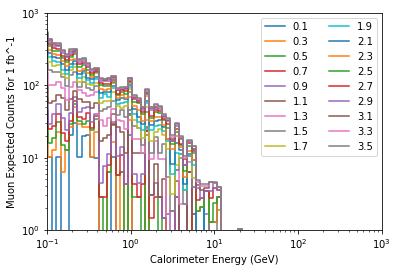

In [15]:
%%time
data1 = binSignal(muon_data)

plotBinnedData(data1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 10**3])
plt.ylim([10**0, 10**3])
energies = [e for e in data1.keys() if isinstance(e,float)]
plt.legend([str(np.round(energy,-2)/1000) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Expected Counts for 1 fb^-1');

CPU times: user 981 ms, sys: 0 ns, total: 981 ms
Wall time: 981 ms


Text(0, 0.5, 'Muon Neutrino Expected Counts for 1 fb^-1')

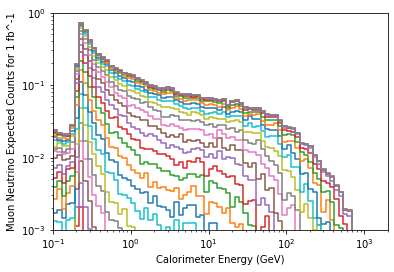

In [16]:
%%time
data2 = binSignal(muon_neutrino_data)

plotBinnedData(data2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 2*10**3])
plt.ylim([10**-3, 10**0])
energies = [e for e in data2.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Neutrino Expected Counts for 1 fb^-1');

CPU times: user 167 ms, sys: 257 µs, total: 167 ms
Wall time: 167 ms


Text(0, 0.5, 'Electron Neutrino Expected Counts for 1 fb^-1')

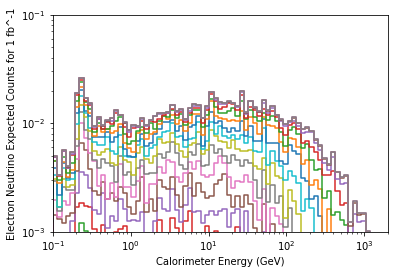

In [17]:
%%time
data3 = binSignal(elec_neutrino_data)

plotBinnedData(data3)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 2*10**3])
plt.ylim([10**-3, 10**-1])
energies = [e for e in data3.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Electron Neutrino Expected Counts for 1 fb^-1');

In [19]:
def printCounts(minCal, scale):
    
    muons = countSignalEvents(muon_data, minCal = minCal)
    muonCount = muons[0]*scale
    muonErr   = muons[1]*scale
    numus = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues   = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: \t\t\t', np.round(muonCount,2), '+/-', np.round(muonErr,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2))
    
LHCrun = 5 # in fb^-1
for minCal in [0, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts(minCal = minCal, scale = LHCrun)
    

For 5 fb^-1 and a calorimeter cut = 0 GeV: 
	Muon: 			 288483.42 +/- 7998.7 
	Muon Neutrino: 		 37.84 +/- 0.95 
	Electron Neutrino: 	 4.73 +/- 0.33
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: 			 3034.19 +/- 714.23 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: 			 171.97 +/- 107.65 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22
For 5 fb^-1 and a calorimeter cut = 10 GeV: 
	Muon: 			 21.28 +/- 21.28 
	Muon Neutrino: 		 5.08 +/- 0.33 
	Electron Neutrino: 	 1.78 +/- 0.2
For 5 fb^-1 and a calorimeter cut = 15 GeV: 
	Muon: 			 5.14 +/- 5.14 
	Muon Neutrino: 		 4.07 +/- 0.29 
	Electron Neutrino: 	 1.52 +/- 0.18
For 5 fb^-1 and a calorimeter cut = 20 GeV: 
	Muon: 			 0 +/- 0 
	Muon Neutrino: 		 3.42 +/- 0.26 
	Electron Neutrino: 	 1.35 +/- 0.17
For 5 fb^-1 and a calorimeter cut = 25 GeV: 
	Muon: 			 0 +/- 0 
	Muon Neutrino: 		 2.91 +/- 0.23 
	Electron Neutrino: 	 1.2 +/- 0.15
For 5 fb^-

# Estimating rates for high energy deposits

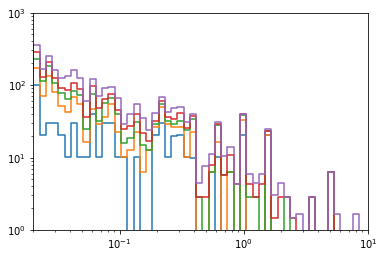

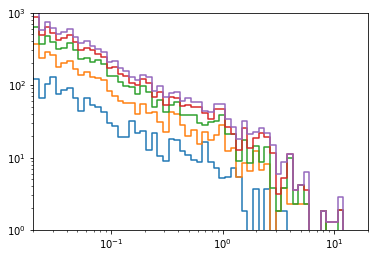

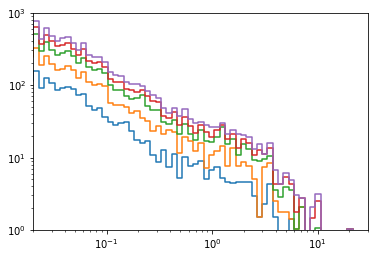

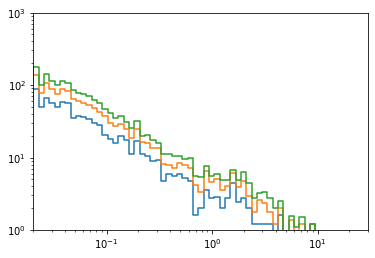

In [20]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))

mask = (primEnergies > 0) & (primEnergies < 1000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 1000) & (primEnergies < 2000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 2*10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 2000) & (primEnergies < 3000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 3*10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 3000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 3*10**1])
plt.ylim([10**0, 10**3]);

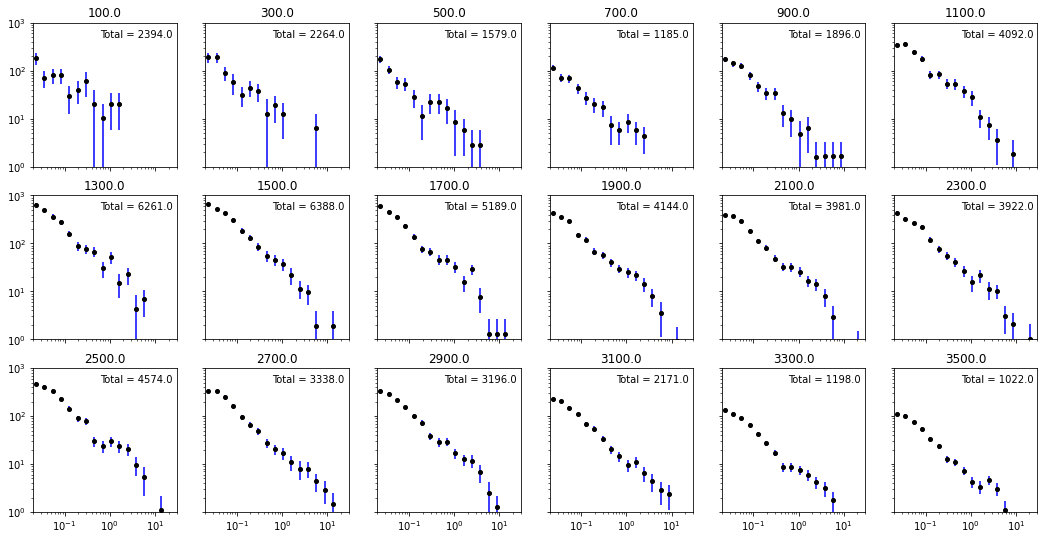

In [21]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))
data1 = binSignal(muon_data, bins=np.logspace(-2,1.5,20), weighted=True)

fig, axs = plt.subplots(3,6, sharex=True, sharey=True,  figsize=(18,9))
axs = [axs[i,j] for i in range(3) for j in range(6)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data1, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([2*10**-2, 3*10**1])
    plt.ylim([10**0, 1000]);
    plt.title(str(np.round(primEnergy,-2)))
    plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))

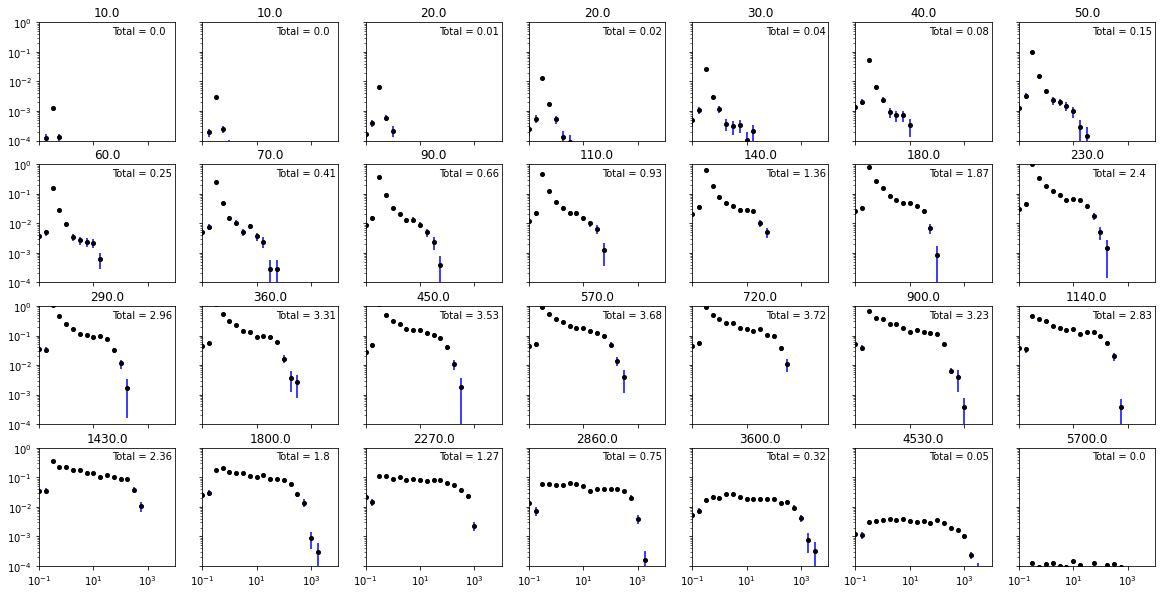

In [22]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_neutrino_data])))
data2 = binSignal(muon_neutrino_data, bins=np.logspace(-2,4,25), weighted=True)

scale = 5
fig, axs = plt.subplots(4,7, sharex=True, sharey=True, figsize=(20,10))
axs = [axs[i,j] for i in range(4) for j in range(7)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data2, primaryEnergies = [primEnergy], scale = scale)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**4])
    plt.ylim([10**-4, 10**0]);
    plt.title(str(np.round(primEnergy,-1)))
    plt.text(5*10**1, 4*10**-1,'Total = ' + str(np.round(counts,2)))

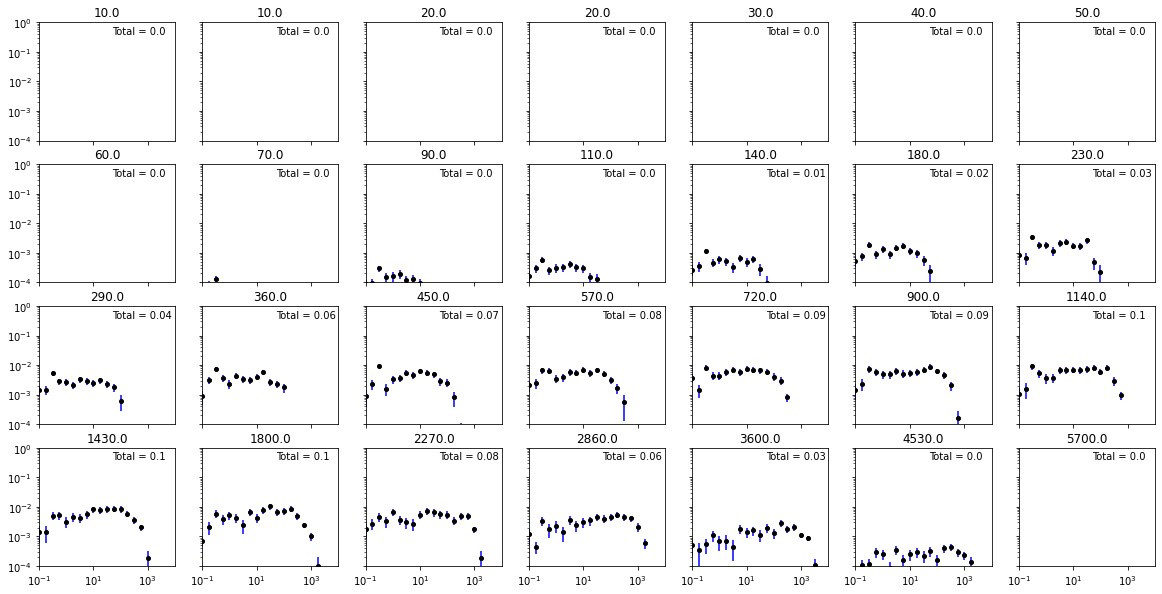

In [23]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in elec_neutrino_data])))
data3 = binSignal(elec_neutrino_data, bins=np.logspace(-2,4,25), weighted=True)

fig, axs = plt.subplots(4,7, sharex=True, sharey=True, figsize=(20,10))
axs = [axs[i,j] for i in range(4) for j in range(7)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data3, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**4])
    plt.ylim([10**-4, 10**0]);
    plt.title(str(np.round(primEnergy,-1)))
    plt.text(5*10**1, 4*10**-1,'Total = ' + str(np.round(counts,2)))

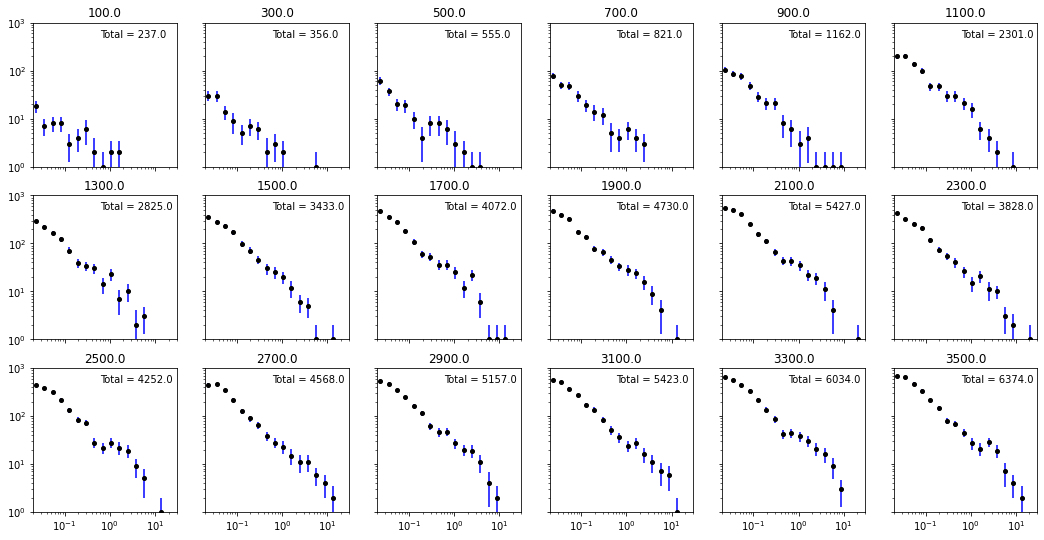

In [24]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))
data1_unweighted = binSignal(muon_data, bins=np.logspace(-2,1.5,20), weighted=False)

fig, axs = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
axs = [axs[i,j] for i in range(3) for j in range(6)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data1_unweighted, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([2*10**-2, 3*10**1])
    plt.ylim([10**0, 1000]);
    plt.title(str(np.round(primEnergy,-2)))
    plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))

In [116]:
from sklearn.linear_model import LinearRegression


def modelData(binData):
    bins = binData['bins'][1:]
    primaryEnergies = [e for e in binData.keys() if isinstance(e,float)]

    models = {}
    x = np.reshape(np.log10(bins),(np.size(bins),1))
    for en in primaryEnergies:
        y = binData[en][0][1:]
        err = binData[en][1][1:]
        mask = y > 0
        y = np.reshape(np.log10(y[mask]),(np.sum(mask),1))
        weights = 1/err[mask]
        model = LinearRegression().fit(x[mask],y, weights)
        y_pred = model.predict(x[mask])
        
        models[en] = model
    
    return models

def plotModels(binData, models, weights = None):
    primaryEnergies = models.keys()
    x_new = np.linspace(-4,3,1000)
    energies = 10 ** x_new
    
    fig, axs = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
    axs = [axs[i,j] for i in range(3) for j in range(6)]
    for (primEnergy, ax) in zip(primaryEnergies,axs):
        if weights is None:
            weight = 1
        else:
            weight = weights[primEnergy]
            
        plt.sca(ax)
        counts = plotCounts(binData, primaryEnergies = [primEnergy])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([10**-3, 310**2])
        plt.ylim([10**0, 1000]);
        plt.title(str(np.round(primEnergy,-2)))
        plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))
        
        model = models[primEnergy]
        y_new = model.predict(x_new[:, np.newaxis])
        counts_pred = 10 ** y_new * weight
        plt.plot(energies, counts_pred, '--r')

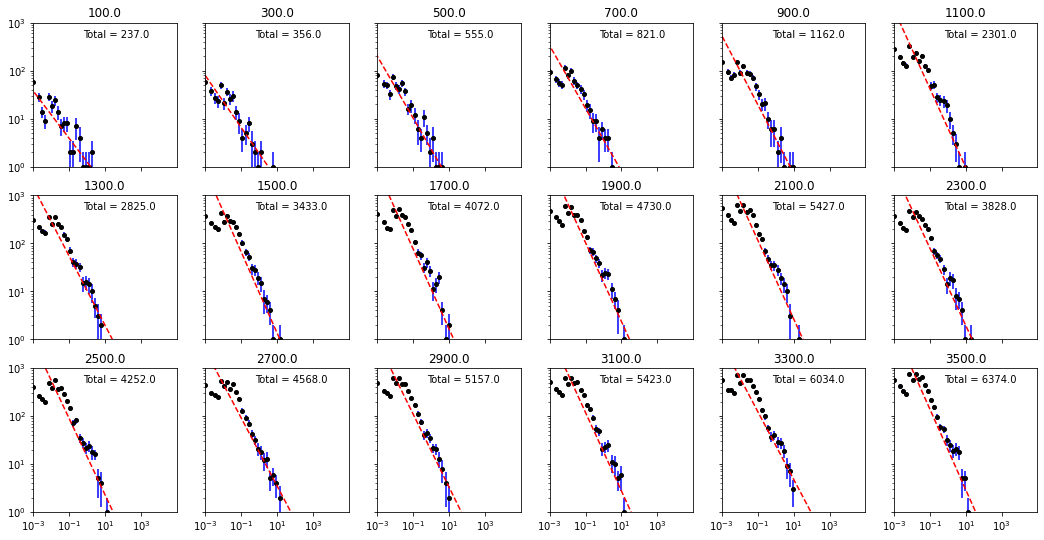

In [117]:
unweighted_muons = binSignal(muon_data, bins=np.logspace(-3,2,30), weighted=False)
unweighted_models = modelData(unweighted_muons)
plotModels(unweighted_muons,unweighted_models)

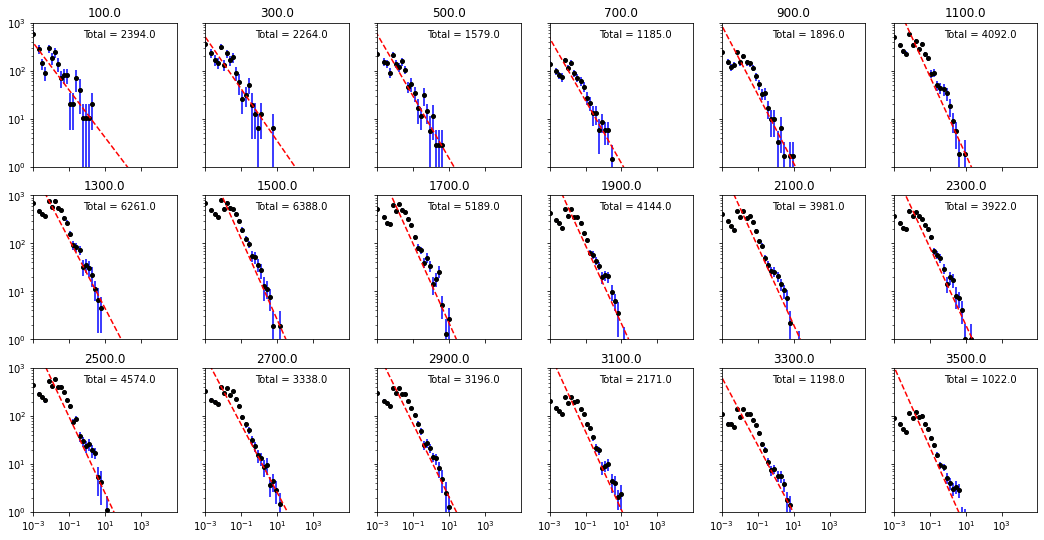

In [118]:
weighted_muons = binSignal(muon_data, bins=np.logspace(-3,2,30))
weighted_models = modelData(weighted_muons)
plotModels(weighted_muons, weighted_models)

In [160]:
def integrateModel(models, E_min = 1):
    x = np.log10([E_min])
    
    count = 0
    for model in models.values():
        a = model.coef_
        b = model.intercept_
        curCount = ((10 ** b)/(1-a) * (E_min ** (a-1)))[0][0]
        count += curCount
    return count


E_min = 1
for (model1, model2) in zip(weighted_models.values(), unweighted_models.values()):
    print(model1.coef_[0][0],model2.coef_[0][0])
    print('***')
    print(model1.intercept_[0],model2.intercept_[0])
    print('---------')
for E_min in [1, 5, 10, 15, 20, 25, 30]:
    print(integrateModel(weighted_models, E_min = E_min), integrateModel(unweighted_models, E_min = E_min))

-0.4936577238547681 -0.4936283404767041
***
1.1063330096637134 0.10157964389911528
---------
-0.5418519050455463 -0.5421469360111146
***
1.0795060382556172 0.27550529738662993
---------
-0.646765174277805 -0.6471598473302914
***
0.8128143683744222 0.35827860784181326
---------
-0.6535584714015729 -0.6543221767204531
***
0.7219591662099294 0.5615174099927365
---------
-0.7177642931753762 -0.7182076886253563
***
0.7903145187889622 0.5781670000129042
---------
-0.8177532497244004 -0.8237305504184709
***
1.0634788345788981 0.8050716970650301
---------
-0.7185701143093107 -0.7224178783654901
***
1.3703382793124144 1.0202334350873161
---------
-0.8404454502241557 -0.8464039486190966
***
1.2530677850481624 0.9767514189046562
---------
-0.8262100962858057 -0.8330011642995047
***
1.154080870461478 1.0402375174933831
---------
-0.8166558020156292 -0.8233089475444093
***
1.1415826464948091 1.192378799815715
---------
-0.8172208329350303 -0.8223479576968338
***
1.119465843775063 1.2491625476922117

In [165]:
def printCounts(minCal, scale):
    
#     muons = countSignalEvents(muon_data, minCal = minCal)
#     muonCount = muons[0]*scale
#     muonErr   = muons[1]*scale
    muonCount = integrateModel(weighted_models, E_min = minCal) * scale
    numus = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues   = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
#           '\n\tMuon: \t\t\t', np.round(muonCount,2), '+/-', np.round(muonErr,2),
          '\n\tMuon: \t\t\t', np.round(muonCount,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2))
    
LHCrun = 5 # in fb^-1
for minCal in [10**-1, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts(minCal = minCal, scale = LHCrun)

For 5 fb^-1 and a calorimeter cut = 0.1 GeV: 
	Muon: 			 33206.74 
	Muon Neutrino: 		 32.79 +/- 0.88 
	Electron Neutrino: 	 3.92 +/- 0.3
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: 			 590.15 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: 			 36.48 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22
For 5 fb^-1 and a calorimeter cut = 10 GeV: 
	Muon: 			 11.11 
	Muon Neutrino: 		 5.08 +/- 0.33 
	Electron Neutrino: 	 1.78 +/- 0.2
For 5 fb^-1 and a calorimeter cut = 15 GeV: 
	Muon: 			 5.56 
	Muon Neutrino: 		 4.07 +/- 0.29 
	Electron Neutrino: 	 1.52 +/- 0.18
For 5 fb^-1 and a calorimeter cut = 20 GeV: 
	Muon: 			 3.41 
	Muon Neutrino: 		 3.42 +/- 0.26 
	Electron Neutrino: 	 1.35 +/- 0.17
For 5 fb^-1 and a calorimeter cut = 25 GeV: 
	Muon: 			 2.33 
	Muon Neutrino: 		 2.91 +/- 0.23 
	Electron Neutrino: 	 1.2 +/- 0.15
For 5 fb^-1 and a calorimeter cut = 30 GeV: 
	Muon: 			 1.71 
	Muon Ne

# Attempt to Use Cluster Learning Algorithm to Classify Primary Particles

Begin by organizing the data

# TODO:
Turn tracker data into macro-observables (numhits, centrality, etc.)

In [37]:
# For sparse arrays to feed to sklearn
import scipy.sparse as sparse

def coordsToIndex(x,y):
    x = x + 12
    y = y + 12
    return x + ((y-1) * 25)

def eventToSparse(event):
    n_col = 1 + (25*25)*4
    mat = sparse.lil_matrix(np.zeros((1,n_col)))
    mat[0,0] = event['calorimeter']
    for n in [1, 2, 3, 4]:
        hits = event[f'hits{n}']
        for hit in hits:
            ind = coordsToIndex(hit[0],hit[1])
            mat[0,ind + 625*(n-1)] = hit[2]
    return mat

# Need this scintillator pattern to avoid cosmics and remove the first pair of scintillators
signal  = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
entries = np.array([n for n in range(10)])

muon_matches = [event for event in muon_data if (event['scintillator'][entries] == signal).all()]
numu_matches = [event for event in muon_neutrino_data if (event['scintillator'][entries] == signal).all()]
nue_matches = [event for event in elec_neutrino_data if (event['scintillator'][entries] == signal).all()]

In [21]:
print(len(muon_matches),len(numu_matches),len(nue_matches))

52164 65016 10091


In [38]:
n_col = 1 + (25*25)*4
Xmu_train = sparse.lil_matrix(np.zeros((0, n_col)))
muon_sample = random.sample(muon_matches,1250)
muon_train = muon_sample[:1000]
muon_test  = muon_sample[1000:]
for event in muon_train:
    mat = eventToSparse(event)
    Xmu_train = sparse.vstack((Xmu_train,mat))

In [39]:
n_col = 1 + (25*25)*4
Xnumu_train = sparse.lil_matrix(np.zeros((0, n_col)))
numu_sample = random.sample(numu_matches,1250)
numu_train = numu_sample[:1000]
numu_test  = numu_sample[1000:]
for event in numu_train:
    mat = eventToSparse(event)
    Xnumu_train = sparse.vstack((Xnumu_train,mat))

In [40]:
n_col = 1 + (25*25)*4
Xnue_train = sparse.lil_matrix(np.zeros((0, n_col)))
nue_sample = random.sample(nue_matches,1250)
nue_train = nue_sample[:1000]
nue_test  = nue_sample[1000:]
for event in nue_train:
    mat = eventToSparse(event)
    Xnue_train = sparse.vstack((Xnue_train,mat))

In [41]:
n_col = 1 + (25*25)*4
Xmu_test = sparse.lil_matrix(np.zeros((0, n_col)))
for event in muon_test:
    mat = eventToSparse(event)
    Xmu_test = sparse.vstack((Xmu_test,mat))

In [42]:
n_col = 1 + (25*25)*4
Xnumu_test = sparse.lil_matrix(np.zeros((0, n_col)))
for event in numu_test:
    mat = eventToSparse(event)
    Xnumu_test = sparse.vstack((Xnumu_test,mat))

In [43]:
n_col = 1 + (25*25)*4
Xnue_test = sparse.lil_matrix(np.zeros((0, n_col)))
for event in nue_test:
    mat = eventToSparse(event)
    Xnue_test = sparse.vstack((Xnue_test,mat))

In [44]:
sparse.save_npz('SparseArrays/muon_train_1000.npz',Xmu_train)
sparse.save_npz('SparseArrays/numu_train_1000.npz',Xnumu_train)
sparse.save_npz('SparseArrays/nue_train_1000.npz',Xnue_train)
sparse.save_npz('SparseArrays/muon_test_250.npz',Xmu_test)
sparse.save_npz('SparseArrays/numu_test_250.npz',Xnumu_test)
sparse.save_npz('SparseArrays/nue_test_250.npz',Xnue_test)

In [45]:
from sklearn.neighbors import KNeighborsClassifier

n_col = 1 + (25*25)*4
X_train = sparse.lil_matrix(np.zeros((0, n_col)))
X_train = sparse.vstack((X_train,Xmu_train))
X_train = sparse.vstack((X_train,Xnumu_train))
X_train = sparse.vstack((X_train,Xnue_train))
y_train = np.zeros((3000,))
y_train[1000:2000] = np.ones((1000,))
y_train[2000:] = np.ones((1000,))*2

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [46]:
X_test = sparse.lil_matrix(np.zeros((0, n_col)))
X_test = sparse.vstack((X_test,Xmu_test))
X_test = sparse.vstack((X_test,Xnumu_test))
X_test = sparse.vstack((X_test,Xnue_test))
y_pred = knn.predict(X_test)

In [47]:
y_test = np.zeros((750,))
y_test[250:500] = np.ones((250,))
y_test[500:] = np.ones((250,))*2

print('Number of correct (Muon Neutrinos vs Electron Neutrinos vs Muons):', np.sum(y_pred == y_test))
print('Number of correct (Neutrinos vs Muons):', np.sum((y_pred > 0) == (y_test > 0)))

print('Correct Ratio (Muon Neutrinos vs Electron Neutrinos vs Muons):', np.sum(y_pred == y_test)/np.size(y_pred))
print('Correct Ratio (Neutrinos vs Muons):', np.sum((y_pred > 0) == (y_test > 0))/np.size(y_pred))

Number of correct (Muon Neutrinos vs Electron Neutrinos vs Muons): 421
Number of correct (Neutrinos vs Muons): 556
Correct Ratio (Muon Neutrinos vs Electron Neutrinos vs Muons): 0.5613333333333334
Correct Ratio (Neutrinos vs Muons): 0.7413333333333333


74% Probability seems promising. Note that this is for all possible energy deposits in the calorimeter. Could we improve it by adding a requirement on the calorimeter energy?

In [63]:
mask = (((y_pred > 0) == (y_test > 0)) - 1) < 0
inds = np.where(mask)
wrongs = X_test.tocsr()[inds,0].toarray()

In [68]:
wrongs

array([[1.110e-01],
       [4.600e-02],
       [3.000e-03],
       [7.700e-02],
       [3.817e+00],
       [4.000e-03],
       [5.000e-02],
       [4.300e-02],
       [2.500e-02],
       [1.870e-01],
       [5.000e-03],
       [3.000e-03],
       [7.000e-03],
       [3.000e-03],
       [2.520e-01],
       [6.600e-02],
       [1.500e-02],
       [2.300e-02],
       [2.260e-01],
       [1.000e-03],
       [6.640e-01],
       [2.450e-01],
       [2.770e-01],
       [1.100e-02],
       [1.000e-03],
       [3.200e-02],
       [2.060e-01],
       [5.510e-01],
       [1.000e-03],
       [2.000e-03],
       [4.680e-01],
       [3.570e-01],
       [2.200e-02],
       [4.000e-03],
       [4.490e-01],
       [3.580e-01],
       [2.000e-01],
       [6.770e-01],
       [4.810e-01],
       [2.260e-01],
       [3.690e-01],
       [2.050e-01],
       [2.000e-03],
       [1.156e+00],
       [0.000e+00],
       [4.540e-01],
       [5.310e-01],
       [4.700e-02],
       [1.070e-01],
       [5.320e-01],
